In [2]:
!pip install tldextract -q

     |████████████████████████████████| 93 kB 1.8 MB/s 


In [3]:
!pip install eli5 -q

     |████████████████████████████████| 216 kB 6.1 MB/s 
     |████████████████████████████████| 133 kB 23.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import random
import sys
import os
import tldextract
import warnings
import regex as re
import eli5
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns 
from urllib.parse import urlparse
from nltk.tokenize import RegexpTokenizer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

warnings.filterwarnings("ignore")

In [6]:
url_data = pd.read_csv('phishing_site_urls.csv')
url_data = url_data.rename(columns={"URL": "url", "Label": "label"})
url_data.sample(5)

,url,label
179042,en.wikipedia.org/wiki/Ontario_Highway_417,good
537856,ausameetings.com/url/,bad
515666,docs.google.com/forms/d/e/1FAIpQLSfE9kshYBFSDA...,bad
419930,ranker.com/list/list-of-world_s-fair-locations...,good
404160,newswire.ca/en/story/689103/first-centre-for-a...,good


In [7]:
def url_parsing(url: str):
    try:
        no_scheme = not url.startswith('https://') and not url.startswith('http://')
        if no_scheme:
            parsed_url = urlparse(f"http://{url}")
            return {
                "scheme": None,
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
        else:
            parsed_url = urlparse(url)
            return {
                "scheme": parsed_url.scheme,
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
    except:
        return None

In [8]:
url_data["parsed_url"] = url_data.url.apply(url_parsing)
url_data = pd.concat([
    url_data.drop(['parsed_url'], axis=1),
    url_data['parsed_url'].apply(pd.Series)
], axis=1)
url_data = url_data[~url_data.netloc.isnull()]
url_data

,url,label,scheme,netloc,path,params,query,fragment
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,None,nobell.it,/70ffb52d079109dca5664cce6f317373782/login.Sky...,,cmd=_profile-ach&outdated_page_tmpl=p/gen/fail...,
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,None,www.dghjdgf.com,/paypal.co.uk/cycgi-bin/webscrcmd=_home-custom...,,,
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,None,serviciosbys.com,/paypal.cgi.bin.get-into.herf.secure.dispatch3...,,,
3,mail.printakid.com/www.online.americanexpress....,bad,None,mail.printakid.com,/www.online.americanexpress.com/index.html,,,
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,None,thewhiskeydregs.com,/wp-content/themes/widescreen/includes/temp/pr...,,84784787824HDJNDJDSJSHD//2724782784/,
...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,bad,None,23.227.196.215,/,,,
549342,apple-checker.org/,bad,None,apple-checker.org,/,,,
549343,apple-iclods.org/,bad,None,apple-iclods.org,/,,,
549344,apple-uptoday.org/,bad,None,apple-uptoday.org,/,,,


In [10]:
url_data["length"] = url_data.url.str.len()
url_data["tld"] = url_data.netloc.apply(lambda nl: tldextract.extract(nl).suffix)
url_data['tld'] = url_data['tld'].replace('','None')
url_data["is_ip"] = url_data.netloc.str.fullmatch(r"\d+\.\d+\.\d+\.\d+")
url_data['domain_hyphens'] = url_data.netloc.str.count('-')
url_data['domain_underscores'] = url_data.netloc.str.count('_')
url_data['path_hyphens'] = url_data.path.str.count('-')
url_data['path_underscores'] = url_data.path.str.count('_')
url_data['slashes'] = url_data.path.str.count('/')
url_data['full_stops'] = url_data.path.str.count('.')

In [12]:
def get_num_subdomains(netloc: str) -> int:
    subdomain = tldextract.extract(netloc).subdomain 
    if subdomain == "":
        return 0
    return subdomain.count('.') + 1

url_data['num_subdomains'] = url_data['netloc'].apply(lambda net: get_num_subdomains(net))

In [13]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
def tokenize_domain(netloc: str) -> str:
    split_domain = tldextract.extract(netloc)
    no_tld = str(split_domain.subdomain +'.'+ split_domain.domain)
    return " ".join(map(str,tokenizer.tokenize(no_tld)))
         
url_data['domain_tokens'] = url_data['netloc'].apply(lambda net: tokenize_domain(net))

In [14]:
url_data['path_tokens'] = url_data['path'].apply(lambda path: " ".join(map(str,tokenizer.tokenize(path))))
url_data_y = url_data['label']
url_data.drop('label', axis=1, inplace=True)
url_data.drop('url', axis=1, inplace=True)
url_data.drop('scheme', axis=1, inplace=True)
url_data.drop('netloc', axis=1, inplace=True)
url_data.drop('path', axis=1, inplace=True)
url_data.drop('params', axis=1, inplace=True)
url_data.drop('query', axis=1, inplace=True)
url_data.drop('fragment', axis=1, inplace=True)
url_data

,length,tld,is_ip,domain_hyphens,domain_underscores,path_hyphens,path_underscores,slashes,full_stops,num_subdomains,domain_tokens,path_tokens
0,225,it,False,0,0,1,0,8,125,0,nobell,ffb d dca cce f login SkyPe com en cgi bin ver...
1,81,com,False,0,0,2,1,4,66,1,www dghjdgf,paypal co uk cycgi bin webscrcmd home customer...
2,177,com,False,0,0,1,0,11,161,0,serviciosbys,paypal cgi bin get into herf secure dispatch r...
3,60,com,False,0,0,0,0,2,42,1,mail printakid,www online americanexpress com index html
4,116,com,False,0,0,1,0,7,60,0,thewhiskeydregs,wp content themes widescreen includes temp pro...
...,...,...,...,...,...,...,...,...,...,...,...,...
549341,15,None,True,0,0,0,0,1,1,0,,
549342,18,org,False,1,0,0,0,1,1,0,apple checker,
549343,17,org,False,1,0,0,0,1,1,0,apple iclods,
549344,18,org,False,1,0,0,0,1,1,0,apple uptoday,


In [15]:
class Converter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(url_data, url_data_y, test_size=0.1)

In [17]:
numeric_features = ['length', 'domain_hyphens', 'domain_underscores', 'path_hyphens', 'path_underscores', 'slashes', 'full_stops', 'num_subdomains']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

In [18]:
categorical_features = ['tld', 'is_ip']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
vectorizer_features = ['domain_tokens','path_tokens']
vectorizer_transformer = Pipeline(steps=[
    ('con', Converter()),
    ('tf', TfidfVectorizer())])

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('domvec', vectorizer_transformer, ['domain_tokens']),
        ('pathvec', vectorizer_transformer, ['path_tokens'])
    ])

svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearSVC())])

log_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

nb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])

In [21]:
svc_clf.fit(X_train, y_train)
log_clf.fit(X_train, y_train)
nb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['length', 'domain_hyphens',
                                                   'domain_underscores',
                                                   'path_hyphens',
                                                   'path_underscores',
                                                   'slashes', 'full_stops',
                                                   'num_subdomains']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tld', 'is_ip']

In [22]:
def visualization(name: str, model: BaseEstimator) -> None:
    preds = model.predict(X_test)

    print(name + " score: %.3f" % model.score(X_test, y_test))
    print(classification_report(y_test, preds))
    labels = ['Good', 'Bad']

    conf_matrix = confusion_matrix(y_test, preds)

    font = {'family' : 'normal',
            'size'   : 14}

    plt.rc('font', **font)
    plt.figure(figsize= (10,6))
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap='Blues')
    plt.title("Confusion Matrix for " + name)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

SVC score: 0.986
              precision    recall  f1-score   support

         bad       0.98      0.97      0.98     15662
        good       0.99      0.99      0.99     39272

    accuracy                           0.99     54934
   macro avg       0.99      0.98      0.98     54934
weighted avg       0.99      0.99      0.99     54934



Logistic Regression score: 0.963
              precision    recall  f1-score   support

         bad       0.97      0.89      0.93     15662
        good       0.96      0.99      0.97     39272

    accuracy                           0.96     54934
   macro avg       0.97      0.94      0.95     54934
weighted avg       0.96      0.96      0.96     54934

Naive Bayes score: 0.974
              precision    recall  f1-score   support

         bad       0.96      0.94      0.95     15662
        good       0.98      0.99      0.98     39272

    accuracy                           0.97     54934
   macro avg       0.97      0.96      0.97     54934
weighted avg       0.97      0.97      0.97     54934



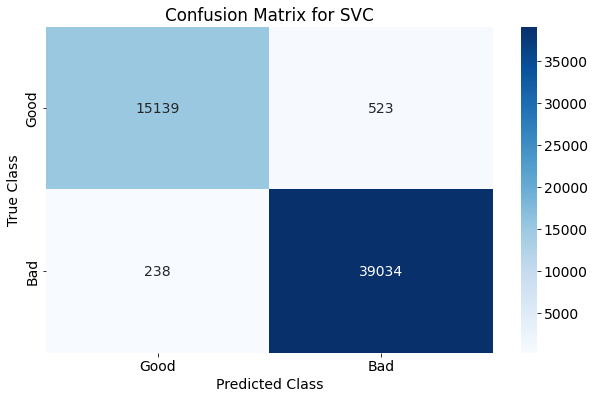

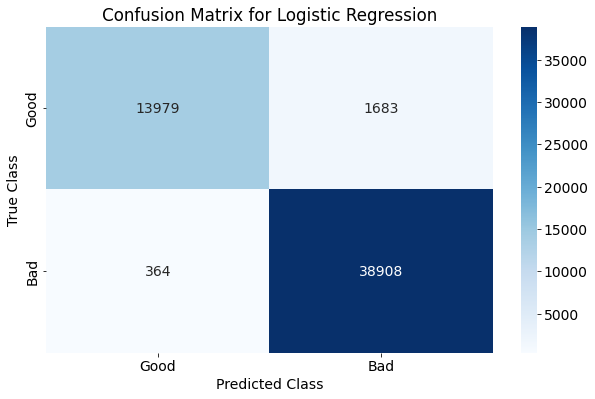

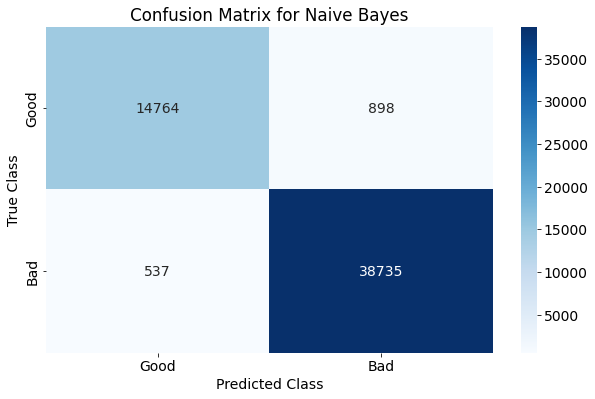

In [23]:
visualization("SVC" , svc_clf)
visualization("Logistic Regression" , log_clf)
visualization("Naive Bayes" , nb_clf)